# Changes
### Most changes between versions are small. All experiments should have only one small change each, so it would be easy to understand how changes affect the result. 

**v1**: Made a functional CNN with 94% accuracy.

**v2**: Resizing to 256 px before cropping. This way we can retain more of the image after the crop, and this helps us too as most of the images are actually focused and centered on the trees. Accuracy boosted to 96%.

**v3**: 30 epochs has been overfitting the model over the validation data. Reduced to 15 epochs. Retains the original 96-97% accuracy as compared to 30 epochs

**v4**: Added L2 regularization while training and used updated model weights for ResNet50 using new API

In [1]:
import numpy as np
from glob import glob
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import ImageFile
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.optim as optim


**Creating our transforms**:
- Cropping to 224 x 224 px for transfer learning model input param. This reduction of the size of the images also helps decrease processing time
- We augumented the dataset to add more training variations by horizontal flipping and slight rotation.  

In [2]:
# Declare the transforms for train, valid and test sets.
# Convert to Tensor
# Normalize images because the values of images should be loaded between [0 - 1]
transforms = {
    
    # RandomHorizontalFlip() & RandomRotation() to augement data in train transformation
    'train' : transforms.Compose([transforms.Resize(256),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomRotation(30),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])]),
    
    'valid' : transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])]),
    
    'test' : transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])])
}

# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
batch_size = 20
# where our data is stored
data_dir = ".\\BarkVN-50_mendeley"

### Data Exploration

We observe that our data has 50 classes/directories with roughly 100 images in each directory. Based on this, we allocated 10% testing, 9% to validation and 81% to training.

We need to be careful of overfitting since this is a small dataset and hence will save the model only when the validation accuracy goes down. 

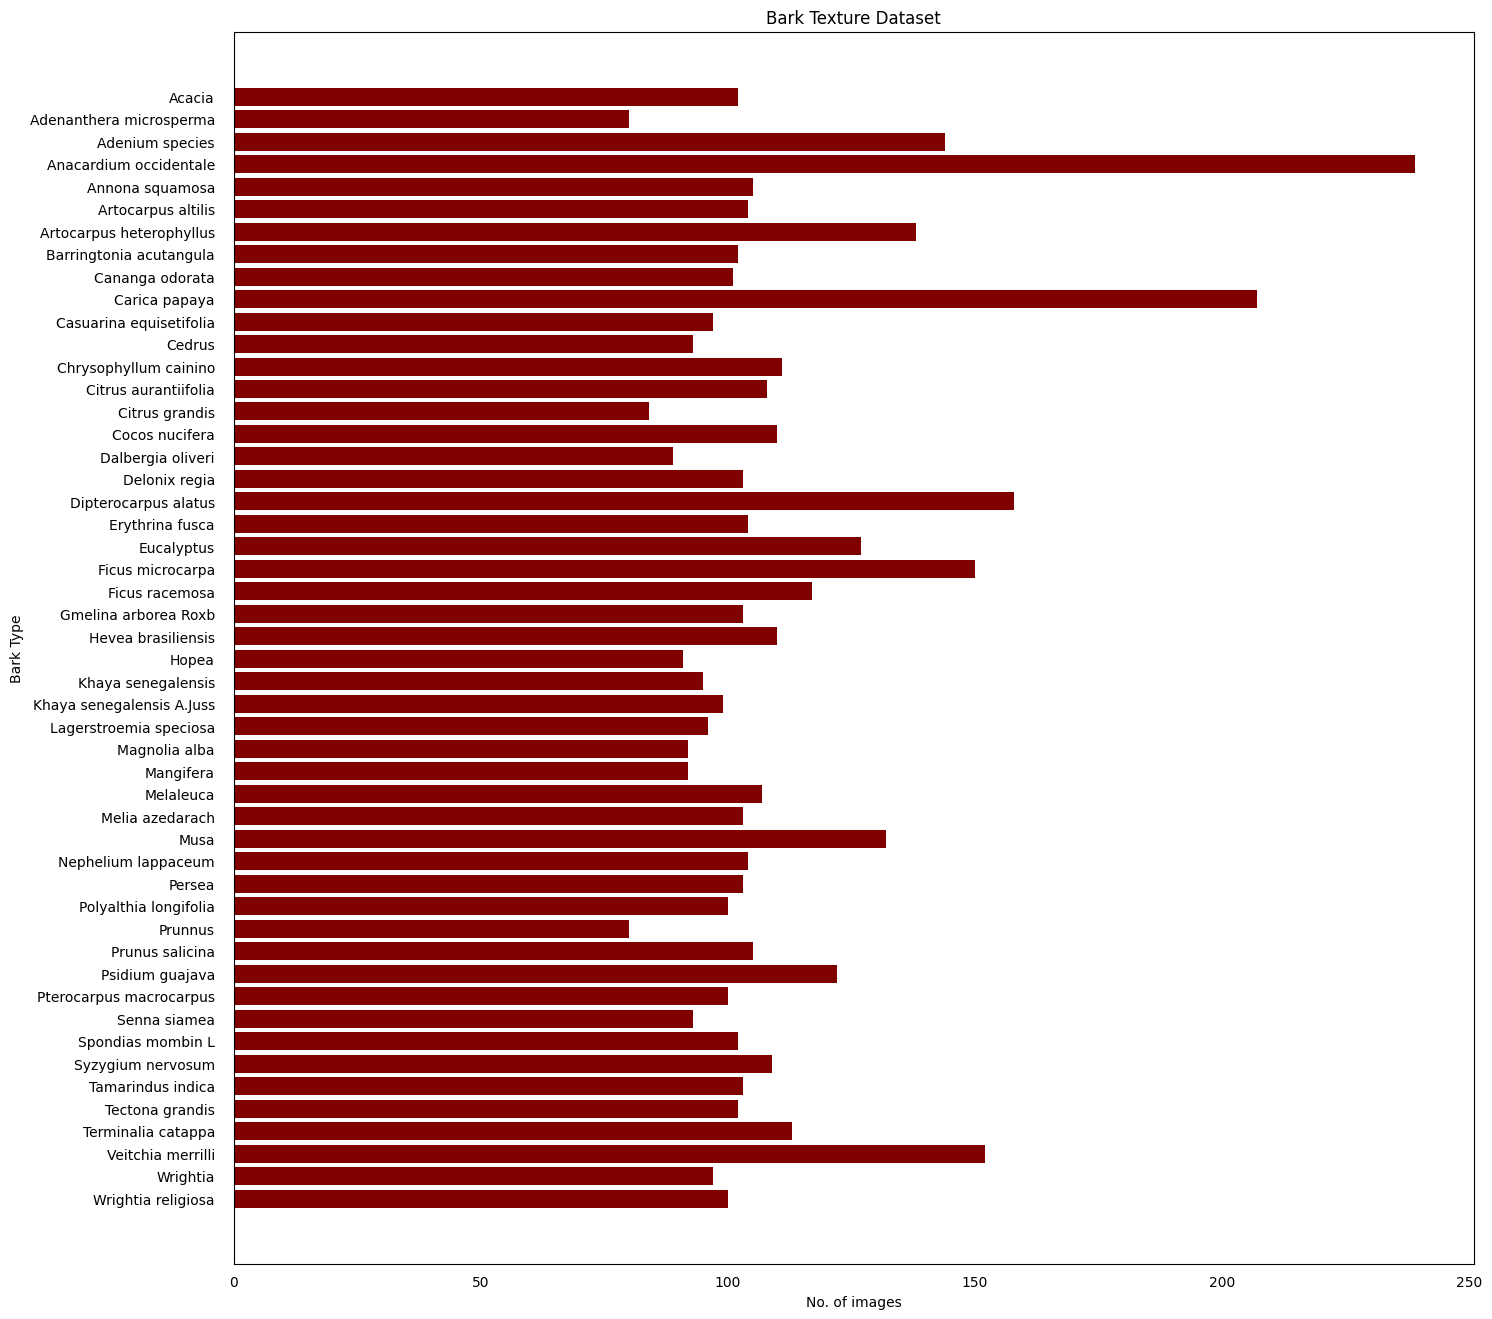

In [3]:
x_plt = []
y_plt = []
for directory in os.listdir(data_dir):
    x_plt.append(directory)
    y_plt.append(len(os.listdir(os.path.join(data_dir, directory))))

# creating the bar plot
fig, ax = plt.subplots(figsize =(16, 16))
plt.barh(x_plt, y_plt, color ='maroon')
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Show top values
ax.invert_yaxis()


plt.ylabel("Bark Type")
plt.xlabel("No. of images")
plt.title("Bark Texture Dataset")
plt.show()

In [4]:
# how much % we want to allocate for testing
test_size=0.1
# how much % of the remaining train data we want to allocate for validation
valid_size=0.1

# load the dataset
train_dataset = datasets.ImageFolder(
    root=data_dir, transform=transforms["train"],
)

valid_dataset = datasets.ImageFolder(
    root=data_dir, transform=transforms["valid"],
)

test_dataset = datasets.ImageFolder(
    root=data_dir, transform=transforms["test"],
)

num_train = len(train_dataset)
indices = list(range(num_train))

# Splitting test into test and train
split = int(np.floor(test_size * num_train))

np.random.shuffle(indices)

train_idx, test_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Splitting remaining test into test and validation
split = int(np.floor(valid_size * num_train))

np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Creating dataloaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler,num_workers=num_workers
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers
)

In [5]:
dataloaders = {
    "train": train_loader,
    "valid": valid_loader,
    "test": test_loader
}

In [6]:
# Get the all labels
class_names = train_dataset.classes
print(class_names)
len(class_names)

['Acacia', 'Adenanthera microsperma', 'Adenium species', 'Anacardium occidentale', 'Annona squamosa', 'Artocarpus altilis', 'Artocarpus heterophyllus', 'Barringtonia acutangula', 'Cananga odorata', 'Carica papaya', 'Casuarina equisetifolia', 'Cedrus', 'Chrysophyllum cainino', 'Citrus aurantiifolia', 'Citrus grandis', 'Cocos nucifera', 'Dalbergia oliveri', 'Delonix regia', 'Dipterocarpus alatus', 'Erythrina fusca', 'Eucalyptus', 'Ficus microcarpa', 'Ficus racemosa', 'Gmelina arborea Roxb', 'Hevea brasiliensis', 'Hopea', 'Khaya senegalensis', 'Khaya senegalensis A.Juss', 'Lagerstroemia speciosa', 'Magnolia alba', 'Mangifera', 'Melaleuca', 'Melia azedarach', 'Musa', 'Nephelium lappaceum', 'Persea', 'Polyalthia longifolia', 'Prunnus', 'Prunus salicina', 'Psidium guajava', 'Pterocarpus macrocarpus', 'Senna siamea', 'Spondias mombin L', 'Syzygium nervosum', 'Tamarindus indica', 'Tectona grandis', 'Terminalia catappa', 'Veitchia merrilli', 'Wrightia', 'Wrightia religiosa']


50

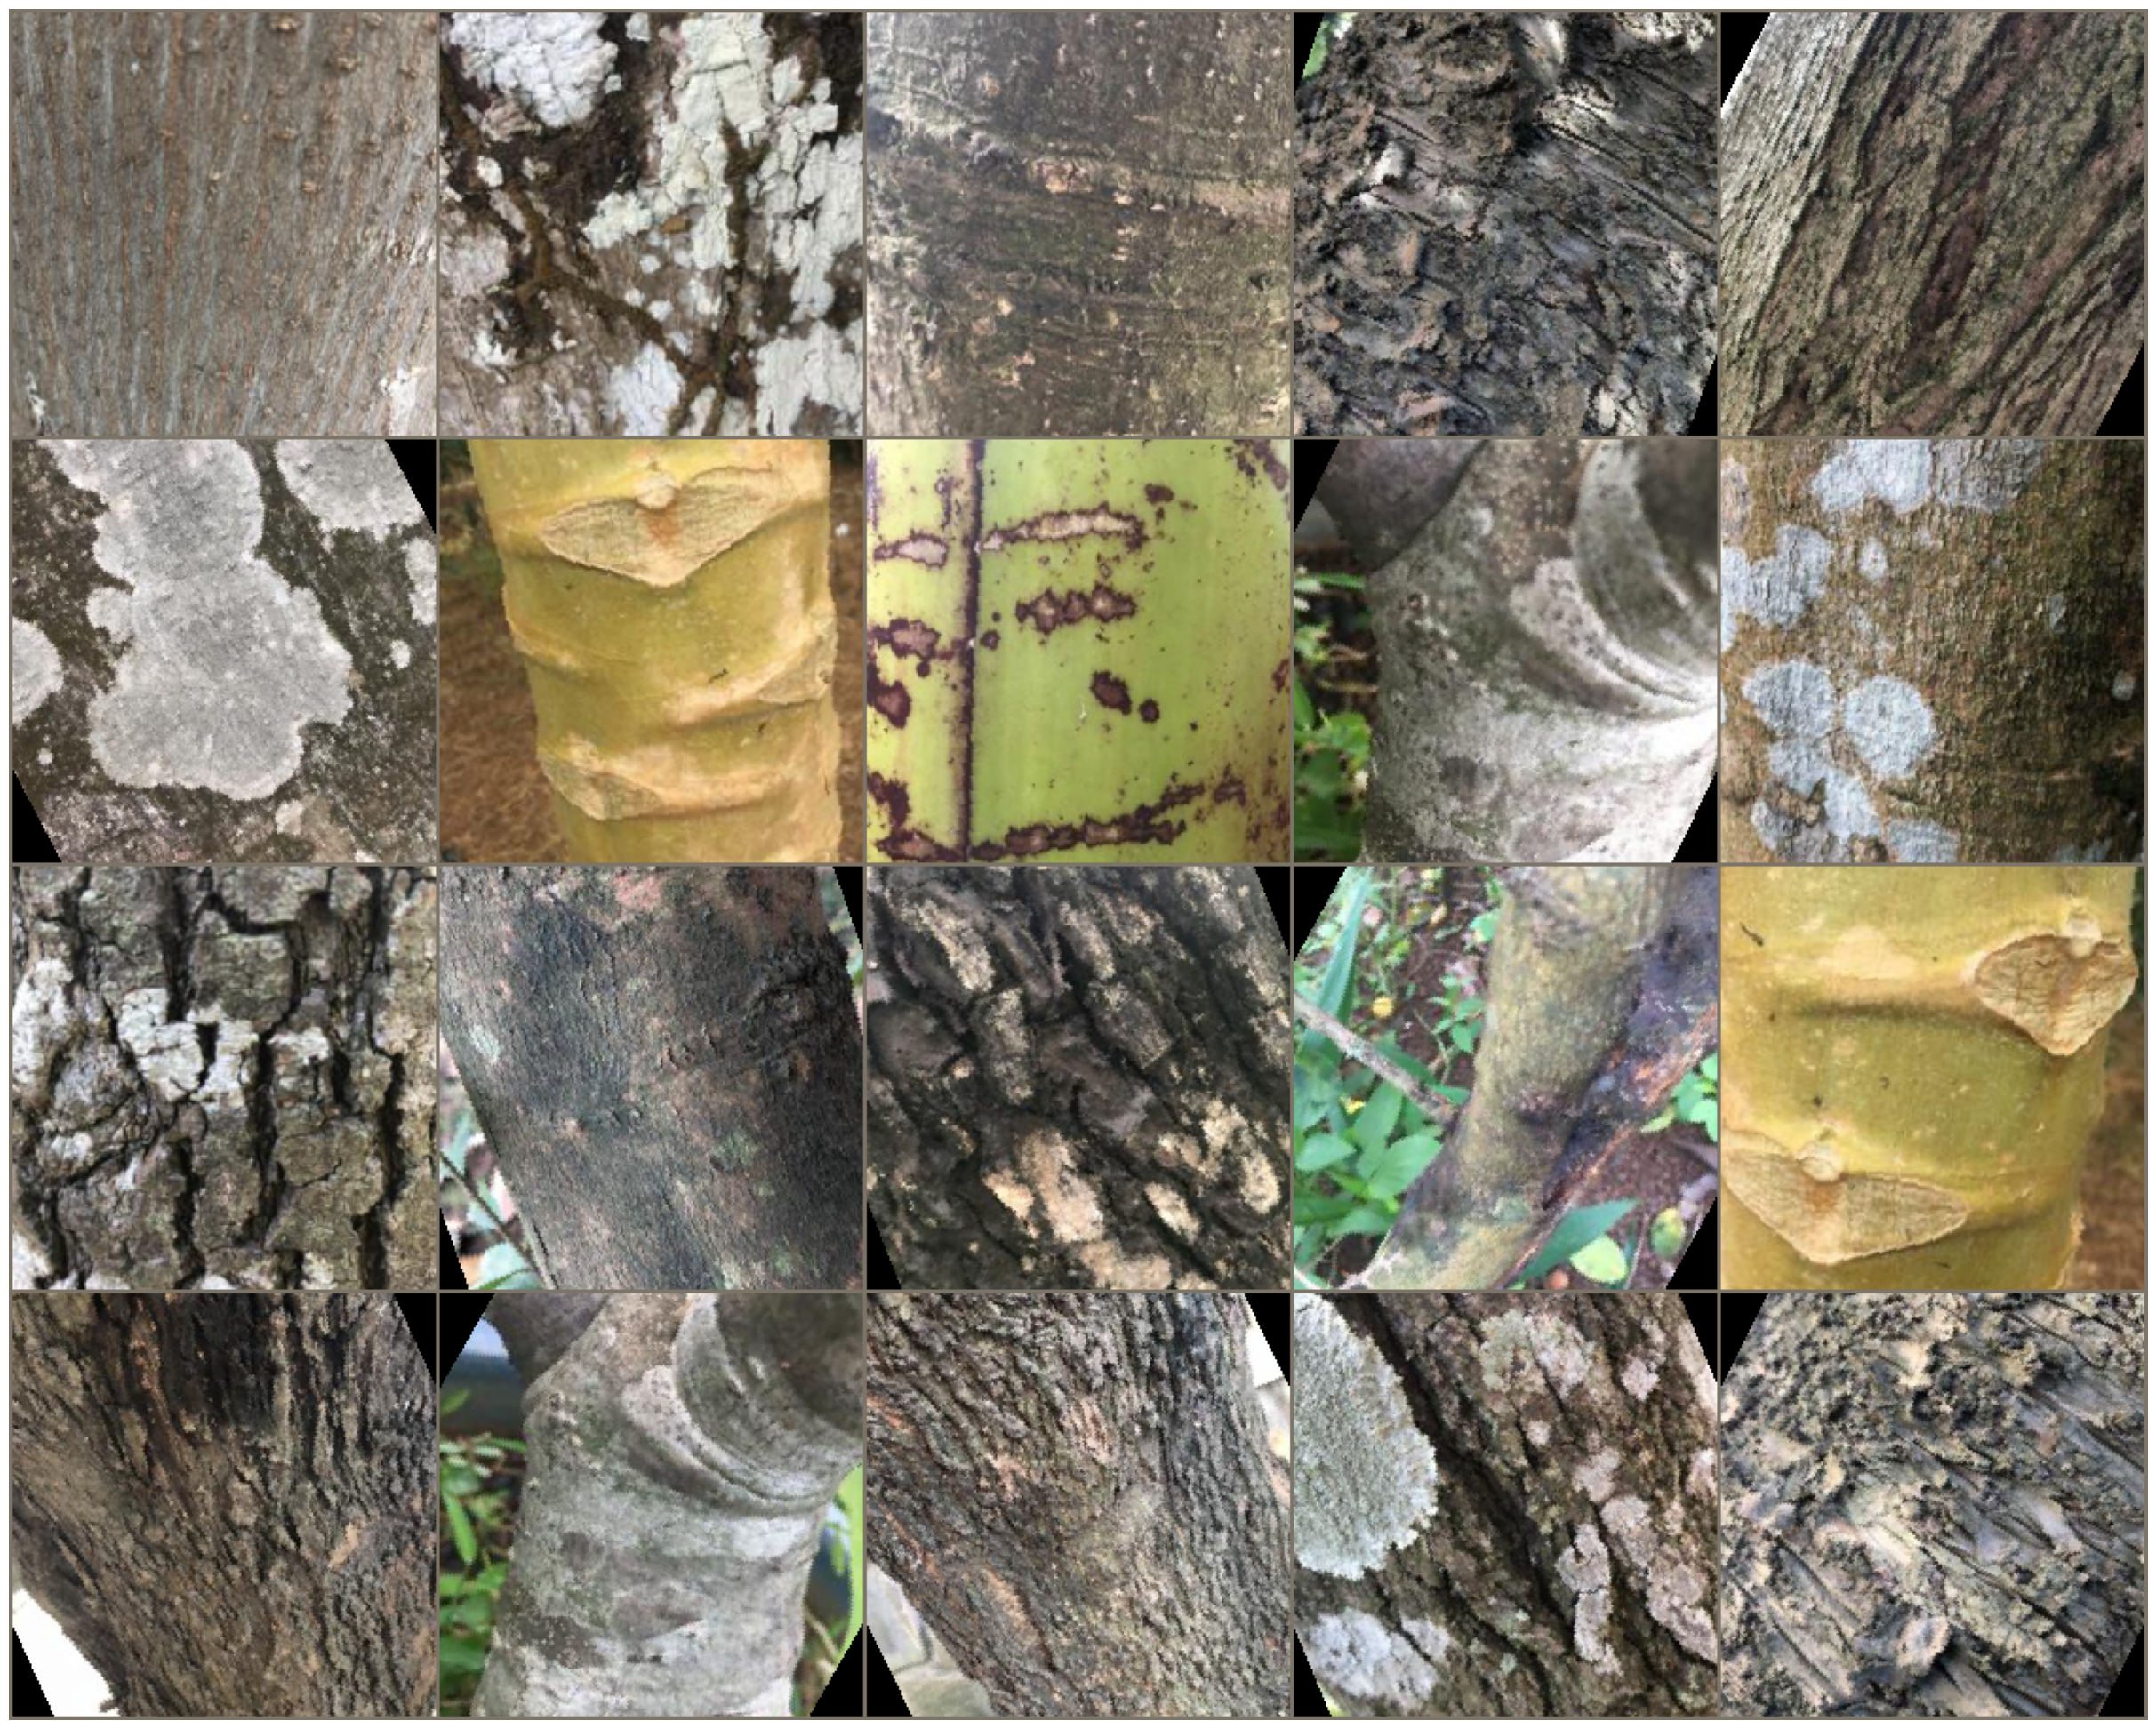

In [7]:
from torchvision import utils

def visualize_sample_images(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = inp * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    inp = np.clip(inp, 0, 1)
    
    fig = plt.figure(figsize=(60, 25))
    plt.axis('off')
    plt.imshow(inp)
    plt.pause(0.001)
    
# Get a batch of training data.    
inputs, classes = next(iter(train_loader))

# Convert the batch to a grid.
grid = utils.make_grid(inputs, nrow=5)

# Display!
visualize_sample_images(grid)

In [12]:
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a Linnear layer with 133 out features
model_transfer.fc = nn.Linear(2048, len(class_names))

use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

RuntimeError: CUDA error: an illegal instruction was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_transfer.fc.parameters(), lr=0.001, weight_decay=5e-5)

In [10]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # clear the gradients of all optimized variables, initialize weights to zero
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # calculate batch loss
            loss = criterion(output, target)
            # backward pass
            loss.backward()
            # parameter update
            optimizer.step()
            # update training loss
            train_loss += loss.item() * data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass
            output = model(data)
            # batch loss
            loss = criterion(output, target)
            # update validation loss
            valid_loss += loss.item() * data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).    Saving model...'.
                 format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


In [11]:
# train the model
model_transfer =  train(45, dataloaders, model_transfer, optimizer, criterion, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 1.651880 	Validation Loss: 0.079432
Validation loss decreased (inf --> 0.079432).    Saving model...
Epoch: 2 	Training Loss: 0.667499 	Validation Loss: 0.046017
Validation loss decreased (0.079432 --> 0.046017).    Saving model...
Epoch: 3 	Training Loss: 0.484552 	Validation Loss: 0.041336
Validation loss decreased (0.046017 --> 0.041336).    Saving model...
Epoch: 4 	Training Loss: 0.403616 	Validation Loss: 0.030953
Validation loss decreased (0.041336 --> 0.030953).    Saving model...


RuntimeError: CUDA error: an illegal instruction was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [ ]:
test(dataloaders, model_transfer, criterion, use_cuda)